# Setup

## Installs

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gpxpy
import folium

In [2]:
GPX_FILE_PATH = '../gpx/'
HARD_SLOPE_THRESHOLD = 0.1 # Threshold to consider a section as hard

colors = {
    'main': '#f53b57',
    'secondary': '#3c40c6',
    'tertiary': '#ffdd59',
}

# Processing the GPX files

In [3]:
# Read the GPX file
gpx_file_name = 'wtr-campos-19-2024.gpx'
full_gpx_file_path = os.path.join(GPX_FILE_PATH, gpx_file_name)
gpx_file = gpxpy.parse(open(full_gpx_file_path))

# Only extract the first track and segment
track = gpx_file.tracks[0]
segment = track.segments[0]
points = segment.points

# Extract coordinates from points
coordinates = np.array([[point.latitude, point.longitude, point.elevation] for point in points])
center_coordinates = np.mean(
    coordinates[:, :2],  # Only use latitude and longitude
    axis=0
)

# Get basic statistics of the route
total_distance = segment.length_3d() # Total distance in meters
total_elevation_gain = segment.get_uphill_downhill().uphill
total_elevation_loss = segment.get_uphill_downhill().downhill

print(f"Total distance: {total_distance/1000:.1f} km")
print(f"Total elevation gain: {round(total_elevation_gain):,} m")
print(f"Total elevation loss: {round(total_elevation_loss):,} m")

# Create a map centered on the center of the coordinates
map = folium.Map(location=center_coordinates, zoom_start=13)

# Add the route to the map
folium.PolyLine(
    coordinates[:, :2],  # Only use latitude and longitude
    weight=3,
    color=colors['main'],
    opacity=0.8
).add_to(map)

# Display the map
map

Total distance: 18.8 km
Total elevation gain: 801 m
Total elevation loss: 801 m


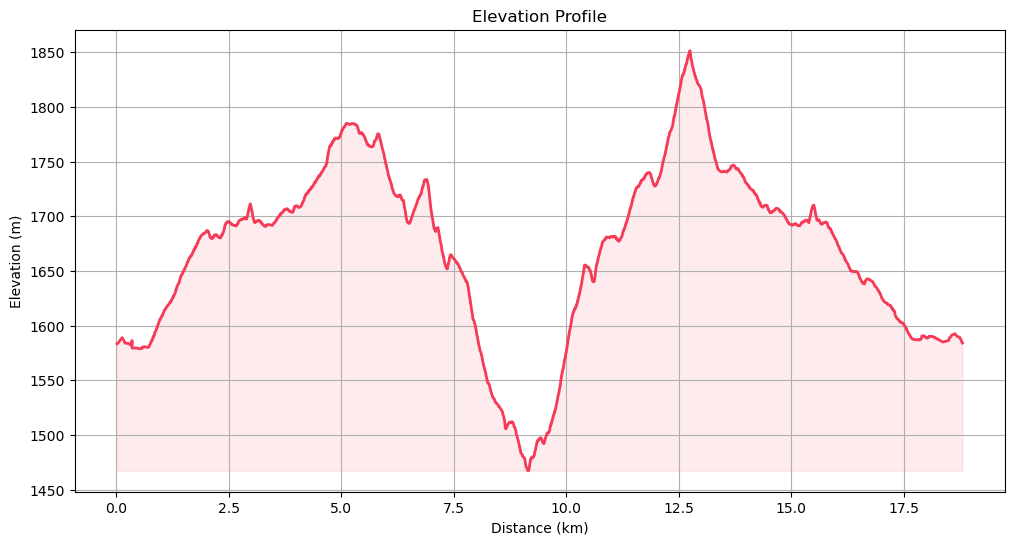

In [4]:
elevations = coordinates[:, 2]
elevation_diff_between_points = np.diff(elevations)

# Calculate the cumulative distance between each point on the route
distance_between_points_3d = np.zeros(len(points) - 1)
distance_between_points_2d = np.zeros(len(points) - 1)

for i in range(0, len(points) - 1):
    distance_between_points_3d[i] = gpxpy.geo.distance(
        coordinates[i, 0],  # latitude1
        coordinates[i, 1],  # longitude1
        coordinates[i, 2],  # elevation1
        coordinates[i+1, 0],   # latitude2
        coordinates[i+1, 1],   # longitude2
        coordinates[i+1, 2],    # elevation2
    )

    distance_between_points_2d[i] = gpxpy.geo.distance(
        coordinates[i, 0],  # latitude1
        coordinates[i, 1],  # longitude1
        0, # Set elevation to 0 for 2D distance
        coordinates[i+1, 0],   # latitude2
        coordinates[i+1, 1],   # longitude2
        0, # Set elevation to 0 for 2D distance
    )

# Calculate cumulative distance and convert to km
cum_distance_3d = np.cumsum(distance_between_points_3d)
cum_distance_3d = cum_distance_3d / 1000

# Calculate slope gradients
slope_gradients = elevation_diff_between_points / distance_between_points_2d

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(
    cum_distance_3d,
    elevations[:-1],
    color=colors['main'],
    linewidth=2
)
plt.fill_between(
    cum_distance_3d,
    elevations[:-1],
    min(elevations),
    alpha=0.1,
    color=colors['main']
)
plt.xlabel('Distance (km)')
plt.ylabel('Elevation (m)')
plt.title('Elevation Profile')
plt.grid(True)
plt.show()

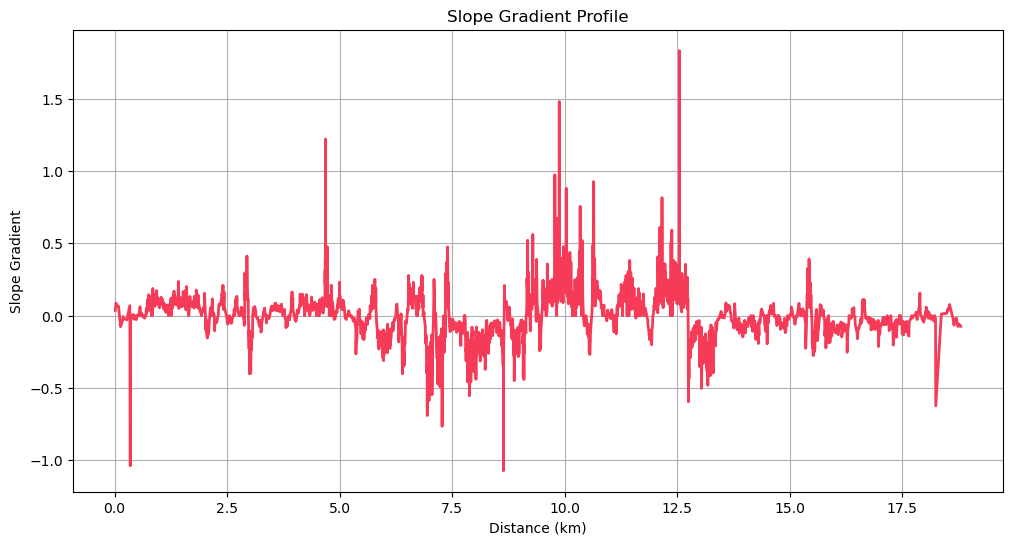

In [5]:
# Plot the slope gradients
plt.figure(figsize=(12, 6))
plt.plot(
    cum_distance_3d,
    slope_gradients,
    color=colors['main'],
    linewidth=2
)
plt.xlabel('Distance (km)')
plt.ylabel('Slope Gradient')
plt.title('Slope Gradient Profile')
plt.grid(True)
plt.show()

In [7]:
# Define the slope bins and labels
slope_bins = np.arange(-1, 1, 0.05).round(2)
slope_bin_labels = [f"{round(100*slope_bins[i])} → {round(100*slope_bins[i+1])}%" for i in range(len(slope_bins) - 1)]

# Make a Pandas DF with the data
df = (
    pd.DataFrame({
        'distance': cum_distance_3d,
        'elevation': elevations[:-1],
        'slope_gradient': slope_gradients
    })
    .assign(
        # Bin the slope gradient into 5% bins
        slope_bin=lambda x: pd.cut(
            x['slope_gradient'] + 0.0001,
            bins=slope_bins,
            right=False,
            labels=slope_bin_labels
        ),
        hard_slope=lambda x: abs(x['slope_gradient']) > HARD_SLOPE_THRESHOLD
    )
)

df

,distance,elevation,slope_gradient,slope_bin,hard_slope
0,0.013884,1583.3,0.036036,0 → 5%,False
1,0.027811,1583.8,0.086486,5 → 10%,False
2,0.057209,1585.0,0.068189,5 → 10%,False
3,0.086601,1587.0,0.064780,5 → 10%,False
4,0.129957,1588.9,-0.076336,-10 → -5%,False
...,...,...,...,...,...
2511,18.708410,1589.7,-0.016849,-5 → 0%,False
2512,18.739317,1589.4,-0.074622,-10 → -5%,False
2513,18.770192,1587.1,-0.058399,-10 → -5%,False
2514,18.787878,1585.3,-0.073704,-10 → -5%,False


% of slopes with gradient > 0.1: 52.0%


/var/folders/q3/cbb_kmc13v1cvh7qwcdm3xs40000gn/T/ipykernel_40220/3290867969.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('slope_bin')


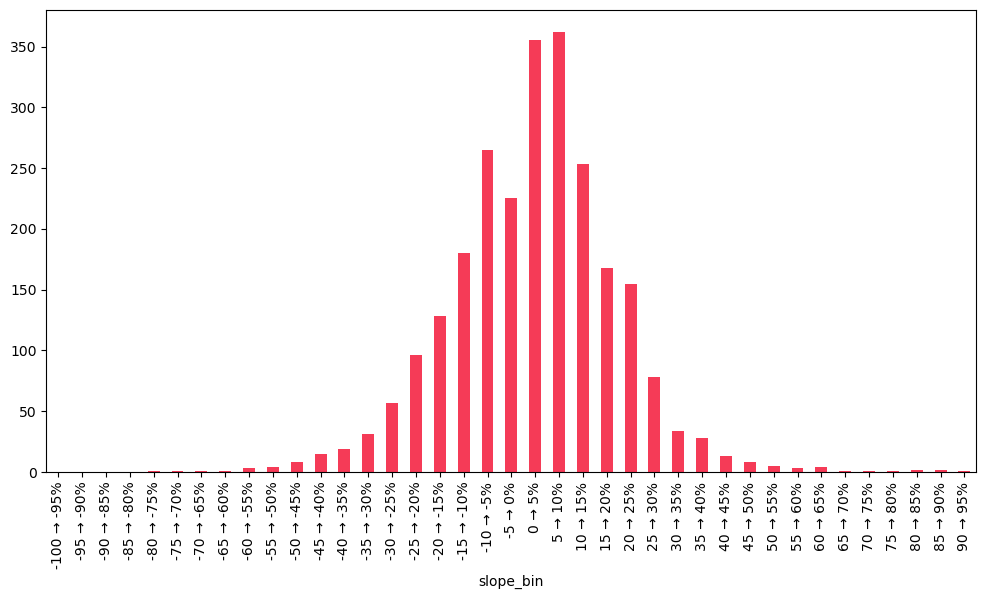

In [8]:
# Plot a histogram of the slope classifications
slope_df = (
    df
    .groupby('slope_bin')
    .size()
)

# % of hard slopes
hard_slope_perc = (
    (
        df
        .groupby('hard_slope')
        .size()/len(df)
    )
    .loc[True]
)

print(f"% of slopes with gradient > {HARD_SLOPE_THRESHOLD}: {100*hard_slope_perc:.1f}%")
# Plot the histogram
(
    slope_df
    .plot(
        kind='bar',
        color=colors['main'],
        figsize=(12, 6),
    )
);